<h1 align="center">OpenMP part 2</h1> 

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [4]:
###variable declarations
nx = 101
ny = 101
nt = 80
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

#solve_2d_nonlinearconv(u, un, v, vn, nt, dt, dx, dy, c)


In [41]:
def solve_2d_nonlinearconv(u:'float[:,:]', un:'float[:,:]', v:'float[:,:]', vn:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', c:'int'):
#def solve_2d_nonlinearconv(u, un, v, vn, nt, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #$ omp parallel
    #$ omp for collapse(3)
    
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        for i in range(1, row): 
            for j in range(1,col):
                u[i,j] = un[i,j] - un[i,j]  * dt / dx * (un[i,j] - un[i-1,j]) - vn[i,j]  * dt / dy * (un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - un[i,j]  * dt / dx * (vn[i,j] - vn[i-1,j]) - vn[i,j]  * dt / dy * (vn[i,j] - vn[i,j-1])
    
    #$ omp end parallel
    
    return 0

if __name__ == '__main__':
    from pyccel.epyccel import epyccel
    from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
    
    threads = 9
    temps_execution = []
    for i in range(1,threads):
        omp_set_num_threads(i)
        execute = epyccel(solve_2d_nonlinearconv, language="c", accelerators= ' openmp ')
        import timeit
        t1 = timeit.default_timer()

        execute(u, un, v, vn, nt, dt, dx, dy, c)
        temps_execution.append(timeit.default_timer() - t1)
    print(temps_execution) 

[0.008006993999970291, 0.008034638000026462, 0.008053004999965196, 0.008038928000132728, 0.008220109999911074, 0.008209622999856947, 0.00789673799999946, 0.0082280560000072]


In [25]:
import matplotlib.pyplot as plt

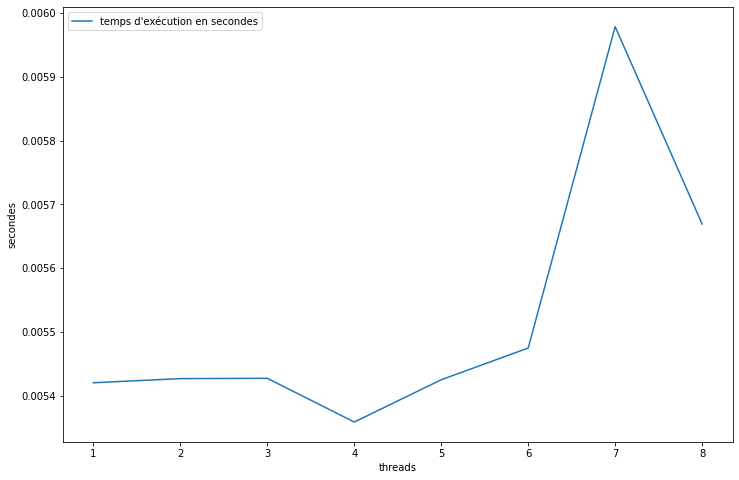

In [29]:
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [31]:
# write your code here
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time
import sympy as sp
from sympy.utilities.lambdify import lambdify
from sympy import init_printing
init_printing(use_latex=True)

In [45]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))


In [79]:
def build_up_b_pyccel(b:'float[:,:]', rho:'int', dt:'float', u:'float[:,:]', v:'float[:,:]', dx:'float', dy:'float'):
    row, col = p.shape
    #$ omp parallel
    #$ omp reduction(+:b) reduction(*:b)
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    #$ omp end parallel
    return b

def pressure_poisson_pyccel(p:'float[:,:]', dx:'float', dy:'float', b:'float[:,:]'):
    pn = np.empty_like(p)
    pn[:,:] = p[:,:]
    
    #$ omp parallel
    #$ omp for reduction(+:p) reduction(*:p)
    for q in range(nit):
        pn[:,:] = p[:,:]
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
    #$ omp end parallel
    return p



In [120]:
u = np.zeros((5, 5))
vn = np.empty_like(u)
vn
help( np.empty_like)

Help on function empty_like in module numpy:

empty_like(...)
    empty_like(prototype, dtype=None, order='K', subok=True, shape=None)
    
    Return a new array with the same shape and type as a given array.
    
    Parameters
    ----------
    prototype : array_like
        The shape and data-type of `prototype` define these same attributes
        of the returned array.
    dtype : data-type, optional
        Overrides the data type of the result.
    
        .. versionadded:: 1.6.0
    order : {'C', 'F', 'A', or 'K'}, optional
        Overrides the memory layout of the result. 'C' means C-order,
        'F' means F-order, 'A' means 'F' if ``prototype`` is Fortran
        contiguous, 'C' otherwise. 'K' means match the layout of ``prototype``
        as closely as possible.
    
        .. versionadded:: 1.6.0
    subok : bool, optional.
        If True, then the newly created array will use the sub-class
        type of 'a', otherwise it will be a base-class array. Defaults
    

In [80]:
def cavity_flow_pyccel(nt:'int', u:'float[:,:]', v:'float[:,:]', dt:'float', nx:'int', ny:'int', dx:'float', dy:'float', p:'float[:,:]', rho:'int', nu:'float'):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    #$ omp parallel
    #$ omp for reduction(+:u) reduction(*:u)
    
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        
        b = build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_pure(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        #$ omp end parallel

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [83]:
if __name__ == '__main__':

    threads = 9
    temps_execution1 = []
    for i in range(1,threads):
        omp_set_num_threads(i)
        execute1 = epyccel(cavity_flow_pyccel, language="c", accelerators= 'openmp')

        t1 = timeit.default_timer()

        execute1(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)
        temps_execution1.append(timeit.default_timer() - t1)
    print(temps_execution1)


ERROR at annotation (semantic) stage
pyccel:
 |fatal [semantic]: mod_62g9d8f7vzx3_62g9d8f7vzx3.py [2,9]| Undefined variable (np)



PyccelSemanticError: Semantic step failed

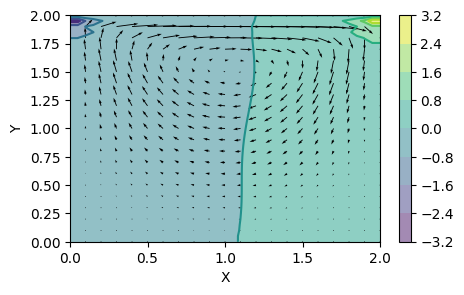

In [78]:
u, v, p = cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');